# Topography. Define anatomical boundaries

Part of Obenhaus et al. 

Draw anatomical boundaries on MEC in [Napari](https://napari.org/) so you can use this as a filter downstream

In [2]:
# Set up basics
import sys, os
import numpy as np
import pandas as pd
import datajoint as dj
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

# Make plots pretty 
sns.set(style='white')
%config InlineBackend.figure_format = 'retina'

In [3]:
sys.path.append('..')
from dj_schemas import *

In [4]:
# Load base schema
schema = dj.schema(dj.config['dj_imaging.database'])
schema.spawn_missing_classes()

# Load personal schema 
imhotte = dj.schema('user_horsto_imaging')
imhotte.spawn_missing_classes()

Connecting horsto@kavlidatajoint02.it.ntnu.no:3306


In [5]:
sys.path.append('..')
from helpers_topography.utils import *

In [6]:
from helpers_topography.fov_stitching import *

In [7]:
from helpers_topography.napari_view import *
# Important, create QT context for Napari
%gui qt

In [8]:
from dj_schemas.anatomical_masks import *
from dj_schemas.utils import *

### Filter sessions

In [9]:
animal_name = '87244'
filtered_sessions = get_filtered_sessions(animal_name, filter_occupancy=False, verbose=True)

87244 
Session type: Open Field
18 unfiltered sessions of type "Open Field"
18 filtered sessions


### Sessions that do not have matching anatomical mask entry 

In [10]:
filtered_sessions.proj(dataset_ = 'dataset_name') - AnatomicalMask.proj()

metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",sessiontype Name for Session Type,dataset_ 16 character hash,"trackingparams_id Parameter set ID, starting with A"


### Session data

In [11]:
# bd69a7d0bc9b40a2 is similar to 01ace4ffafe6aefc

In [12]:
session_name = 'dbc7e204d3b73727'
session_key  = filtered_sessions.proj(data='dataset_name') & f'session_name = "{session_name}"' 
projection_data = (ProjectionCorr & session_key & 'center_plane=0').fetch1()

### Check whether there is already an entry available for this session

In [13]:
(AnatomicalMask & projection_data)

setup_name Setup name,setup_timestamp Timestamp of setup configuration,scope_name Scope name,zoom Zoom level,metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",dataset_name 16 character hash,center_plane imaging plane of this projection,timestamp_mask_lookup Auto created timestamp,anat_mask Anatomical mask for regions in FOV
Mini Blue,2019-02-01 00:00:00,Bolt,1.000,088eaba999b6c42f,0,dbc7e204d3b73727,d0ce443e23c9b913,0,2020-08-06 09:22:19,=BLOB=


### Create Napari instance and draw in labels

In [14]:
anatomical_mask_dict = AnatomicalMaskParams().fetch1()
viewer, label_layer_name = label_anatomy_napari(projection_data, anatomical_mask_dict, session_name)

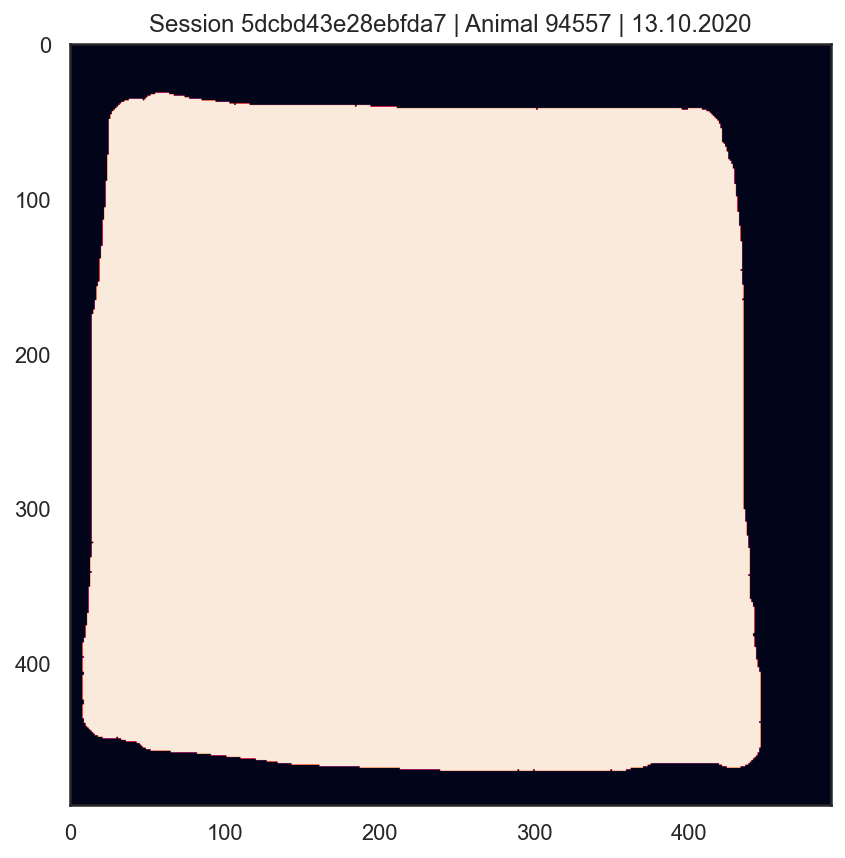

In [763]:
# Receive label map
data = viewer.layers[label_layer_name].as_layer_data_tuple()
anatomical_mask = data[0]
figure = plt.figure(figsize=(7,7))
plt.imshow(anatomical_mask)
plt.title(f'{session_title_string(session_name)}');

### Insert into table `AnatomicalMask`

Logic: Retrieve from `AnatomicalMaskParams` the most recent entry (which should be the one matching the current label configuration)

In [764]:
unique_labels_lut = set([value for value in anatomical_mask_dict.values() if isinstance(value,int)])
unique_labels_map = set(anatomical_mask.astype(int).flatten())
unique_labels_map.discard(0)
if not all(elem in unique_labels_lut for elem in unique_labels_map): 
    raise KeyError('Labels found in anatomical map not found in LUT')

In [765]:
anatomicalmask_dict = {
    ** projection_data,
    ** anatomical_mask_dict,
    **{'anat_mask'  : anatomical_mask}
    }    

In [766]:
AnatomicalMask.insert1(anatomicalmask_dict, ignore_extra_fields=True, skip_duplicates=False)
print(f'Success. AnatomicalMask now has {len(AnatomicalMask())} entries')

Success. AnatomicalMask now has 142 entries


### Make sure that all planes are covered

In [ ]:
for entry_anat_mask in AnatomicalMask:
    _ = entry_anat_mask.pop('center_plane')
    if len(ProjectionCorr & entry_anat_mask) > 1:
        print(f'More than one plane in session {entry_anat_mask["session_name"]}')
        for center_plane in (ProjectionCorr & entry_anat_mask).fetch('center_plane'):
            entry_anat_mask['center_plane'] = center_plane
            try:
                AnatomicalMask.insert1(entry_anat_mask, skip_duplicates=False)
            except dj.errors.DuplicateError:
                print('Already exists. Skipping.')

### Fetch results and display

In [16]:
mec_cells = (RoisCorr.proj('center_x_corr','center_y_corr') & RoisCorrBrainLoc.MEC & projection_data)
pas_cells = (RoisCorr.proj('center_x_corr','center_y_corr') & RoisCorrBrainLoc.PAS & projection_data)

In [17]:
center_coords_mec = np.stack(mec_cells.fetch('center_x_corr','center_y_corr'))
center_coords_pas = np.stack(pas_cells.fetch('center_x_corr','center_y_corr'))

In [18]:
anatomical_mask = (AnatomicalMask & projection_data).fetch1('anat_mask')

In [19]:
x_min,x_max,y_min,y_max = get_x_y_lim(anatomical_mask,padding=0,thresh=0)

In [25]:
len(center_coords_mec[0]), len(center_coords_pas[0])

(32, 108)

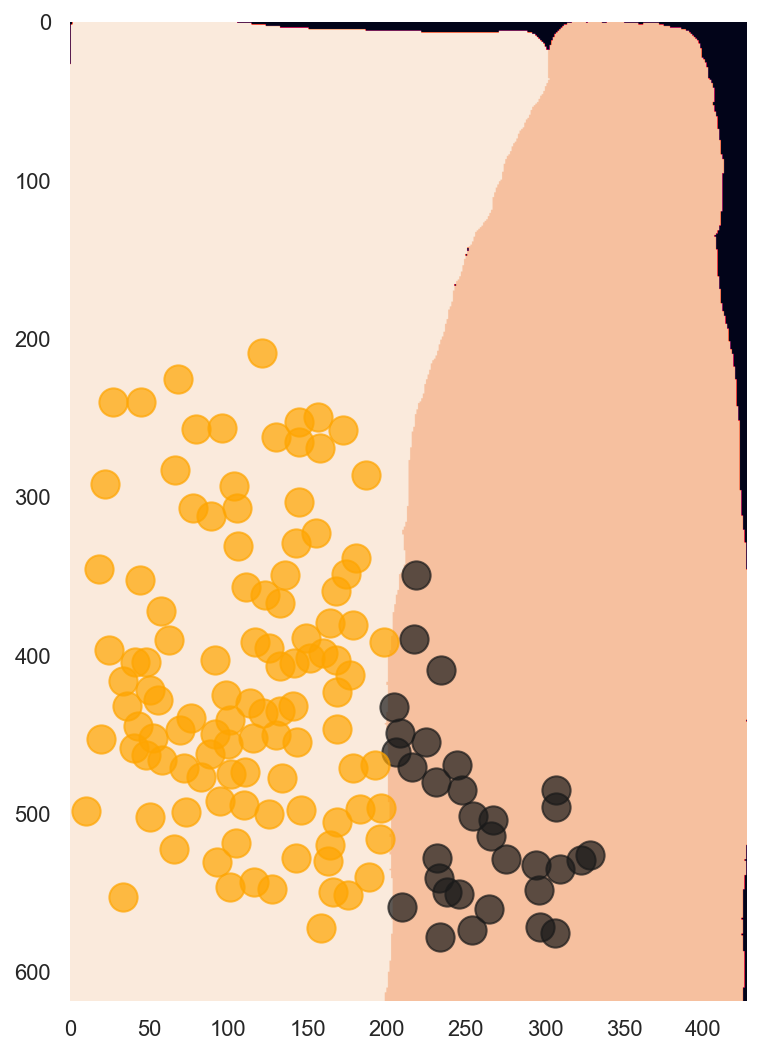

In [20]:
figure = plt.figure(figsize=(7,9))
ax = figure.add_subplot(111)
ax.imshow(anatomical_mask)
ax.scatter(center_coords_mec[0,:],center_coords_mec[1,:],marker='o',s=200, color='k', alpha=.7)
ax.scatter(center_coords_pas[0,:],center_coords_pas[1,:],marker='o',s=200, color='orange', alpha=.7)

ax.set_xlim(x_min,x_max); ax.set_ylim(y_min,y_max)
sns.despine(left=True,bottom=True)

In [365]:
#binning_params = ['grid','mvl','border_bvs','ovc']
binning_param_set = 'mvl'
sigma = 0.
statistic = 'nanmean'
metasession_ref = None

region = 'pas_label'
projection_short = 'mean_img'
sigma_mask = 2.

In [340]:
animal_name = '87244'
animal_name

'87244'

In [376]:
AnatomicalMaskParams()

timestamp_mask_lookup Auto created timestamp,mec_label Medial entorhinal cortex (MEC) label name (integer),pas_label Parasubiculum label name (integer),rsa_label Retrosplenial agranular cortex (integer),prh_label Perirhinal cortex
2020-08-06 09:22:19,8,9,None,None
